## Placebo and sensitivity analysis (trustworthiness guardrails)

This notebook focuses on guardrails that prevent overconfidence:

- Placebo-in-time: fake intervention dates in the pre-period.
- Leave-one-covariate-out: check robustness to dropping a control.
- Drop last K days of pre: check stability to pre-window choice.
- Window sensitivity: evaluate impact across multiple analysis windows.

We also save plots that can be reused for an article.

In [2]:
import sys
from pathlib import Path

repo_root = Path.cwd()
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tecore.causal import DataSpec, ImpactConfig, ImpactMethod, run_impact
from tecore.causal.simulate_ts import SyntheticTSConfig, generate_synthetic_time_series
from tecore.causal.sensitivity import leave_one_covariate_out_test, drop_last_k_days_of_pre_test

## 1) Generate a synthetic dataset with a known effect

In [3]:
cfg = SyntheticTSConfig(
    n_days=240,
    start_date="2025-01-01",
    intervention_day=150,
    level_shift=10.0,
    slope_change=0.0,
    temp_effect_amp=5.0,
    temp_effect_decay=0.10,
    confounding=False,
    random_state=20,
)

df, meta = generate_synthetic_time_series(cfg)
intervention_date = meta["intervention_date"]
print("Intervention:", intervention_date)
print("True cumulative effect (synthetic):", meta.get("true_cum_effect"))
df.head()

Intervention: 2025-05-31
True cumulative effect (synthetic): 952.5351755679424


,date,y,sessions,active_users,marketing_spend,external_index
0,2025-01-01,91.875045,974.284642,201.264458,313.887450,44.824326
1,2025-01-02,110.627657,1065.063589,203.629611,290.507608,54.496813
2,2025-01-03,125.565395,1050.320694,207.273899,341.529380,58.864391
3,2025-01-04,102.854663,1013.303837,194.369003,314.686941,50.571884
4,2025-01-05,106.238068,1070.670974,192.578553,326.848360,51.349508


## 2) Run causal impact (with placebo)

In [4]:
spec = DataSpec(
    date_col="date",
    y_col="y",
    x_cols=["sessions", "active_users", "marketing_spend", "external_index"],
    freq="D",
    add_time_trend=True,
    add_day_of_week=True,
)

cfg_run = ImpactConfig(
    intervention_date=intervention_date,
    method=ImpactMethod.CAUSAL_IMPACT_LIKE,
    ridge_alpha=1.0,
    bootstrap_iters=300,
    block_size=7,
    alpha=0.05,
    run_placebo=True,
    n_placebos=40,
    pre_period_min_points=60,
)

res = run_impact(df, spec, cfg_run)
res.summary()

{'method': 'causal_impact_like',
 'intervention_date': '2025-05-31',
 'point_effect': 8.225723217974684,
 'point_ci': (7.409535466762337, 8.990905962372862),
 'cum_effect': 740.3150896177216,
 'cum_ci': (666.8581920086103, 809.1815366135576),
 'rel_effect': 0.041593691863922665,
 'rel_ci': (0.037466606508941194, 0.045462868402775955),
 'p_value': 0.3333333333333333,
 'warnings': [],
 'diagnostics': {'r2_pre': 0.974460264283277,
  'rmse_pre': 4.1855540836096745,
  'acf_lag1': 0.03862695346806884,
  'acf_lag2': -0.04964335313681931,
  'acf_lag3': -0.07241704039669503,
  'acf_lag4': -0.12949326022006097,
  'acf_lag5': 0.1075112277711664,
  'acf_lag6': 0.12485422551490513,
  'acf_lag7': 0.10359789247716553,
  'max_abs_acf_1_to_7': 0.12949326022006097},
 'economics': None}

### Plot: observed vs counterfactual

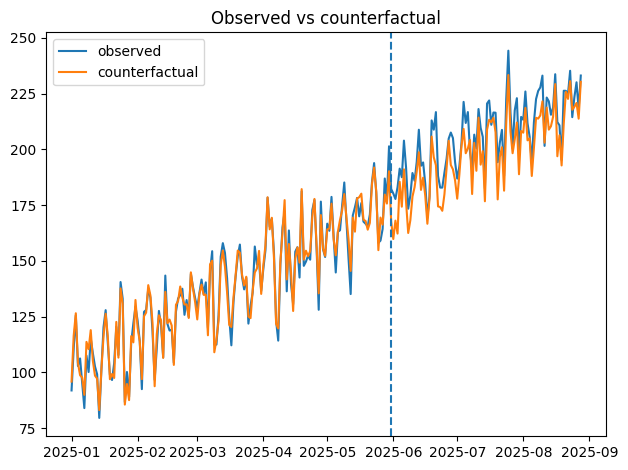

In [5]:
eff = res.effect_series.copy()
eff["date"] = pd.to_datetime(eff["date"])

plt.figure()
plt.plot(eff["date"], eff["y"], label="observed")
plt.plot(eff["date"], eff["y_hat"], label="counterfactual")
plt.axvline(pd.Timestamp(intervention_date), linestyle="--")
plt.title("Observed vs counterfactual")
plt.legend()
plt.tight_layout()
plt.show()

### Plot: placebo distribution

Estimated cumulative effect: 740.315
Placebo p-value: 0.3333333333333333


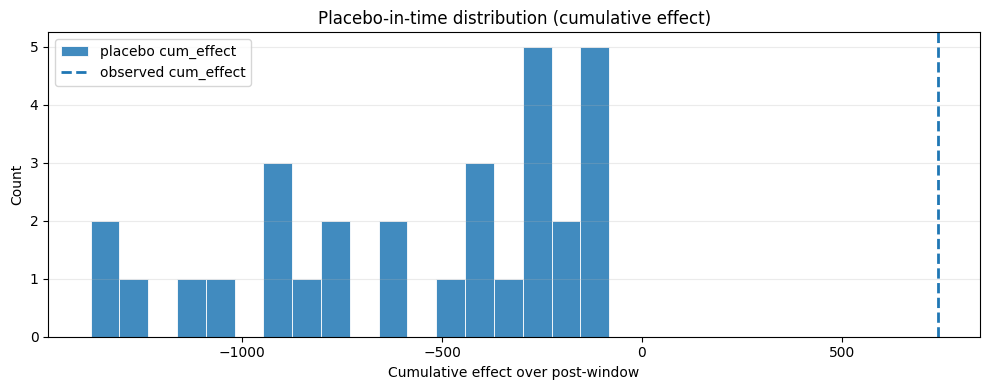

In [7]:
if res.placebo_results is None or len(res.placebo_results) == 0:
    print("Placebo not available.")
else:
    x = res.placebo_results["cum_effect"].to_numpy(dtype=float)
    x = x[np.isfinite(x)]

    plt.figure(figsize=(10, 4))

    plt.hist(x, bins=18, density=False, alpha=0.85, edgecolor="white", linewidth=0.7, label="placebo cum_effect")

    plt.axvline(float(res.cum_effect), linestyle="--", linewidth=2, label="observed cum_effect")

    plt.title("Placebo-in-time distribution (cumulative effect)")
    plt.xlabel("Cumulative effect over post-window")
    plt.ylabel("Count")
    plt.grid(True, axis="y", alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Estimated cumulative effect: {float(res.cum_effect):.3f}")
    print(f"Placebo p-value: {res.p_value}")

## 3) Sensitivity: leave-one-covariate-out

In [8]:
loo = leave_one_covariate_out_test(df, spec, cfg_run)
loo

,scenario,cum_effect,rel_effect
0,all_features,740.315090,0.041594
1,drop:sessions,727.100971,0.040821
2,drop:active_users,697.958510,0.039121
3,drop:marketing_spend,742.051180,0.041695
4,drop:external_index,759.256910,0.042703


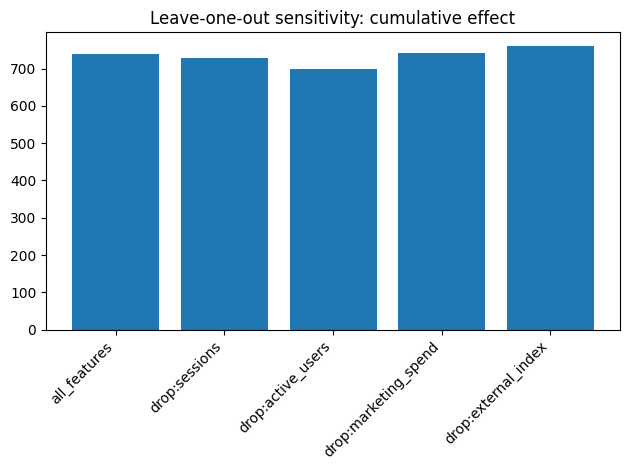

In [9]:
# Plot as bars for quick visual comparison
plt.figure()
plt.bar(loo["scenario"], loo["cum_effect"])
plt.title("Leave-one-out sensitivity: cumulative effect")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 4) Sensitivity: drop last K days of pre
If dropping a small portion of the pre-period changes the estimate dramatically, treat results as fragile.

In [10]:
stab = drop_last_k_days_of_pre_test(df, spec, cfg_run, k_list=[7, 14, 21, 28])
stab

,scenario,cum_effect,rel_effect
0,baseline,740.315090,0.041594
1,drop_last_pre:7,777.498704,0.043774
2,drop_last_pre:14,794.634510,0.044782
3,drop_last_pre:21,726.016520,0.040758
4,drop_last_pre:28,723.031238,0.040583


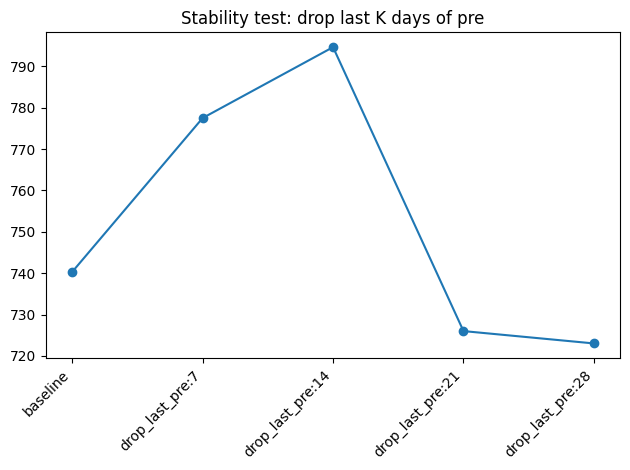

In [11]:
plt.figure()
plt.plot(stab["scenario"], stab["cum_effect"], marker="o")
plt.title("Stability test: drop last K days of pre")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 5) Window sensitivity

We vary the analysis window (how much pre-history is included) while keeping the intervention date fixed.

This helps detect whether conclusions depend on an arbitrary window choice.

In [12]:
def run_with_pre_window_days(df_in, intervention_date, pre_days, post_days=60):
    d = df_in.copy()
    d["date"] = pd.to_datetime(d["date"])
    t0 = pd.Timestamp(intervention_date)
    start = t0 - pd.Timedelta(days=pre_days)
    end = t0 + pd.Timedelta(days=post_days)
    d = d[(d["date"] >= start) & (d["date"] <= end)].copy()
    d["date"] = d["date"].dt.strftime("%Y-%m-%d")

    cfg_local = ImpactConfig(
        intervention_date=intervention_date,
        method=ImpactMethod.CAUSAL_IMPACT_LIKE,
        ridge_alpha=1.0,
        bootstrap_iters=200,
        block_size=7,
        alpha=0.05,
        run_placebo=True,
        n_placebos=25,
        pre_period_min_points=max(20, int(pre_days * 0.6)),
    )
    return run_impact(d, spec, cfg_local)

pre_windows = [30, 45, 60, 90, 120]
rows = []
for w in pre_windows:
    r = run_with_pre_window_days(df, intervention_date, pre_days=w, post_days=60)
    rows.append({
        "pre_days": w,
        "cum_effect": r.cum_effect,
        "cum_ci_low": r.cum_ci[0],
        "cum_ci_high": r.cum_ci[1],
        "p_value": r.p_value,
        "warnings": "; ".join(r.warnings) if r.warnings else ""
    })

win = pd.DataFrame(rows)
win

,pre_days,cum_effect,cum_ci_low,cum_ci_high,p_value,warnings
0,30,282.901490,253.388687,353.454310,NaN,
1,45,354.105866,304.804005,413.969744,NaN,
2,60,465.286915,416.542862,516.841986,NaN,
3,90,649.400125,592.584668,700.437147,NaN,
4,120,581.585687,527.458581,636.586246,0.0,


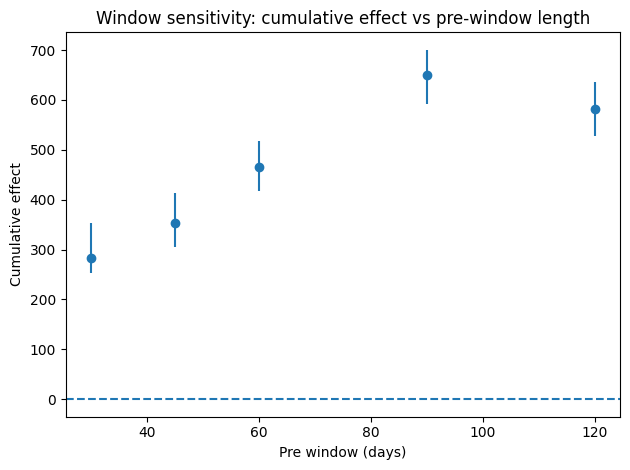

In [13]:
plt.figure()
plt.errorbar(win["pre_days"], win["cum_effect"], 
             yerr=[win["cum_effect"] - win["cum_ci_low"], win["cum_ci_high"] - win["cum_effect"]],
             fmt="o")
plt.axhline(0.0, linestyle="--")
plt.title("Window sensitivity: cumulative effect vs pre-window length")
plt.xlabel("Pre window (days)")
plt.ylabel("Cumulative effect")
plt.tight_layout()
plt.show()

## 6) Save outputs and figures

This block saves CSV tables and key plots under out/notebook_13_placebo_sensitivity/. You can re-use these images for an article.

In [14]:
out_dir = repo_root / "out" / "notebook_13_placebo_sensitivity"
out_dir.mkdir(parents=True, exist_ok=True)

# Save tables
eff_to_save = res.effect_series.copy()
eff_to_save["date"] = pd.to_datetime(eff_to_save["date"]).dt.strftime("%Y-%m-%d")
eff_to_save.to_csv(out_dir / "effect_series.csv", index=False)

if res.placebo_results is not None:
    pl = res.placebo_results.copy()
    pl["placebo_date"] = pd.to_datetime(pl["placebo_date"]).dt.strftime("%Y-%m-%d")
    pl.to_csv(out_dir / "placebo_results.csv", index=False)

loo.to_csv(out_dir / "leave_one_out.csv", index=False)
stab.to_csv(out_dir / "drop_last_k_pre.csv", index=False)
win.to_csv(out_dir / "window_sensitivity.csv", index=False)

# Save plots by re-plotting with savefig
def save_fig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()

# Observed vs counterfactual
plt.figure()
plt.plot(eff["date"], eff["y"], label="observed")
plt.plot(eff["date"], eff["y_hat"], label="counterfactual")
plt.axvline(pd.Timestamp(intervention_date), linestyle="--")
plt.title("Observed vs counterfactual")
plt.legend()
save_fig(out_dir / "observed_vs_counterfactual.png")

# Placebo histogram
if res.placebo_results is not None:
    plt.figure()
    plt.hist(res.placebo_results["cum_effect"].values, bins=18)
    plt.axvline(res.cum_effect, linestyle="--")
    plt.title("Placebo-in-time distribution (cumulative effect)")
    save_fig(out_dir / "placebo_hist.png")

# Leave-one-out bars
plt.figure()
plt.bar(loo["scenario"], loo["cum_effect"])
plt.title("Leave-one-out sensitivity: cumulative effect")
plt.xticks(rotation=45, ha="right")
save_fig(out_dir / "leave_one_out.png")

# Drop last K pre
plt.figure()
plt.plot(stab["scenario"], stab["cum_effect"], marker="o")
plt.title("Stability test: drop last K days of pre")
plt.xticks(rotation=45, ha="right")
save_fig(out_dir / "drop_last_k_pre.png")

# Window sensitivity errorbars
plt.figure()
plt.errorbar(win["pre_days"], win["cum_effect"], 
             yerr=[win["cum_effect"] - win["cum_ci_low"], win["cum_ci_high"] - win["cum_effect"]],
             fmt="o")
plt.axhline(0.0, linestyle="--")
plt.title("Window sensitivity: cumulative effect vs pre-window length")
plt.xlabel("Pre window (days)")
plt.ylabel("Cumulative effect")
save_fig(out_dir / "window_sensitivity.png")

print("Wrote:", out_dir)

Wrote: /data/notebook_files/out/notebook_13_placebo_sensitivity


## Results summary

- We ran **placebo-in-time** tests by shifting the intervention date into the pre-period and re-estimating the cumulative effect, producing an empirical “null” distribution for effects that can arise from noise, seasonality, or model misfit.
- We evaluated **sensitivity to modeling choices** that often drive overconfidence in time-series causal estimates:
  - leave-one-covariate-out stress test,
  - stability to shortening the pre-period (drop-last-*k* pre),
  - stability to alternative pre/post windows.
- The key takeaway is not the point estimate itself, but whether the estimate remains **directionally consistent and reasonably stable** under these perturbations.

### Interpretation

- If the observed cumulative effect lies in the tail of the placebo distribution (small p-value), the result is more consistent with a real intervention effect rather than typical pre-period fluctuations.
- If the estimate changes materially when removing a single covariate or adjusting the window, the result is likely **model-driven** and should be treated as fragile.
- Strong pre-fit metrics alone are insufficient: placebo and sensitivity checks are the primary guardrails against spurious “impact” conclusions.

### Practical checklist

- Placebo distribution: does the observed effect look extreme relative to placebo draws?
- Covariate stress tests: does any single covariate dominate the result?
- Window sensitivity: is the conclusion stable across reasonable pre/post choices?
- If any check fails, prefer a more conservative conclusion (or switch to a design with stronger identification, e.g., donor-based synthetic control or a randomized test).